In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [ ]:
# Step 1: Data Import & Initial Exploration
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
file_path = '/content/drive/MyDrive/FinalDW.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Display dataset info and first rows
print("Dataset Info:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Platform            100000 non-null  object 
 1   Post ID             100000 non-null  int64  
 2   Post Type           100000 non-null  object 
 3   Post Content        100000 non-null  object 
 4   Post Timestamp      100000 non-null  object 
 5   Likes               100000 non-null  int64  
 6   Comments            100000 non-null  int64  
 7   Shares              100000 non-null  int64  
 8   Impressions         100000 non-null  int64  
 9   Reach               100000 non-null  int64  
 10  Engagement Rate     100000 non-null  float64
 11  Audience Age        100000 non-null  int64  
 12  Audience Gender     100000 non-null  object 
 13  Audience Location   100000 non-null  object 
 14  Audience Interests  100000 non-null  object 
 15  Campaign ID         2

In [ ]:
# Check for missing values
print("Missing Values: ")
print(df.isnull().sum())

Missing Values: 
Platform                  0
Post ID                   0
Post Type                 0
Post Content              0
Post Timestamp            0
Likes                     0
Comments                  0
Shares                    0
Impressions               0
Reach                     0
Engagement Rate           0
Audience Age              0
Audience Gender           0
Audience Location         0
Audience Interests        0
Campaign ID           79868
Sentiment             50100
Influencer ID         90006
dtype: int64


In [ ]:
# Step 2: Data Cleaning
## Handle Missing Values
sentiment_mode = df['Sentiment'].mode()[0]
df['Sentiment'] = df['Sentiment'].fillna(sentiment_mode)

In [ ]:
# Map Sentiment to numeric and fill missing Sentiment_numeric values
sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['Sentiment_numeric'] = df['Sentiment'].map(sentiment_mapping)
df['Sentiment_numeric'] = df['Sentiment_numeric'].fillna(0)

In [ ]:
# Drop high missing value columns
df = df.drop(columns=['Campaign ID', 'Influencer ID'], errors='ignore')

In [ ]:
print("\nMissing Values After Handling:")
print(df.isnull().sum())


Missing Values After Handling:
Platform              0
Post ID               0
Post Type             0
Post Content          0
Post Timestamp        0
Likes                 0
Comments              0
Shares                0
Impressions           0
Reach                 0
Engagement Rate       0
Audience Age          0
Audience Gender       0
Audience Location     0
Audience Interests    0
Sentiment             0
Sentiment_numeric     0
dtype: int64


In [ ]:
# Fix Data Types
# Coerce invalid timestamps to NaT
df['Post Timestamp'] = pd.to_datetime(df['Post Timestamp'], errors='coerce')

# Drop rows with invalid timestamps
df = df.dropna(subset=['Post Timestamp'])

# Verify timestamp changes
print("Post Timestamp Sample: ")
print(df['Post Timestamp'].head())

# Step 3: Feature Engineering
# Extract meaningful time-based features: Day/Night or Every 6 hours
def categorize_time(hour):
    if 0 <= hour < 6:
        return "Midnight (12AM-6AM)"
    elif 6 <= hour < 12:
        return "Morning (6AM-12PM)"
    elif 12 <= hour < 18:
        return "Afternoon (12PM-6PM)"
    else:
        return "Night (6PM-12AM)"

df['Post Hour'] = df['Post Timestamp'].dt.hour
df['Post Minute'] = df['Post Timestamp'].dt.minute
df['Time Range'] = df['Post Hour'].apply(categorize_time)

<ipython-input-9-7273da9f9a99>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Post Timestamp'] = pd.to_datetime(df['Post Timestamp'], errors='coerce')


Post Timestamp Sample: 
0    2024-12-18 19:49:18
8    2024-12-18 22:21:06
10   2024-12-18 15:59:48
11   2024-12-18 19:50:24
16   2024-12-18 06:20:06
Name: Post Timestamp, dtype: datetime64[ns]


<ipython-input-9-7273da9f9a99>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Post Hour'] = df['Post Timestamp'].dt.hour
<ipython-input-9-7273da9f9a99>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time Range'] = df['Post Hour'].apply(categorize_time)


In [ ]:
# Step 1: Correct Categorical Columns
categorical_columns = ['Platform', 'Post Type', 'Audience Gender', 'Audience Location', 'Sentiment']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# Step 2: Verify the Changes
print("Data Types After Correction:")
print(df.dtypes)

Data Types After Correction:
Platform                    category
Post ID                        int64
Post Type                   category
Post Content                  object
Post Timestamp        datetime64[ns]
Likes                          int64
Comments                       int64
Shares                         int64
Impressions                    int64
Reach                          int64
Engagement Rate              float64
Audience Age                   int64
Audience Gender             category
Audience Location           category
Audience Interests            object
Sentiment                   category
Sentiment_numeric              int64
Post Hour                      int32
Time Range                    object
dtype: object


In [ ]:
# Step 4: Outlier Removal (Using IQR)
numerical_columns = ['Likes', 'Comments', 'Shares', 'Impressions', 'Reach', 'Engagement Rate']
for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

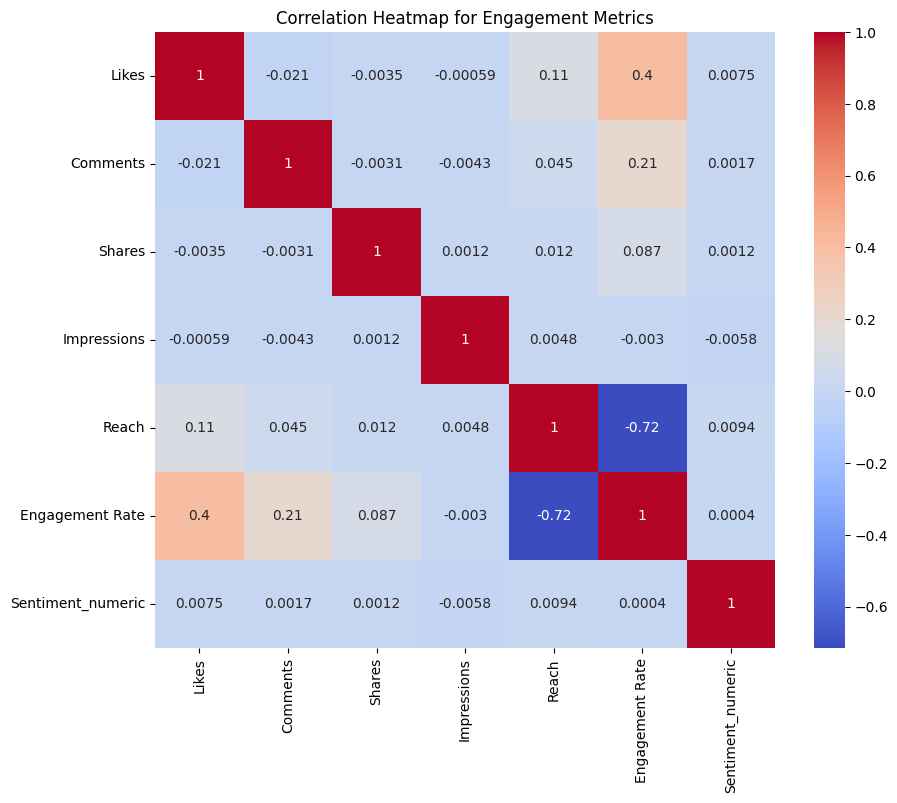

In [ ]:
# Step 5: Exploratory Data Analysis (EDA) Visualizations
## Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_columns + ['Sentiment_numeric']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap for Engagement Metrics")
plt.show()

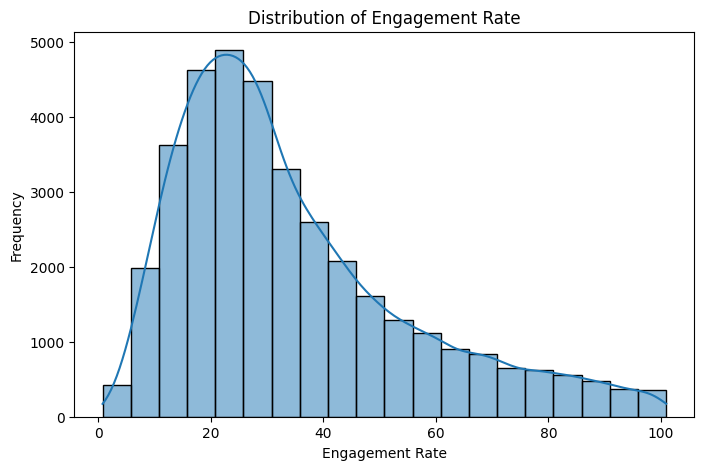

In [ ]:
## Engagement Rate Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['Engagement Rate'], bins=20, kde=True)
plt.title("Distribution of Engagement Rate")
plt.xlabel("Engagement Rate")
plt.ylabel("Frequency")
plt.show()

<ipython-input-16-15bd98f2b6a2>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  platform_engagement = df.groupby('Platform')['Engagement Rate'].mean()


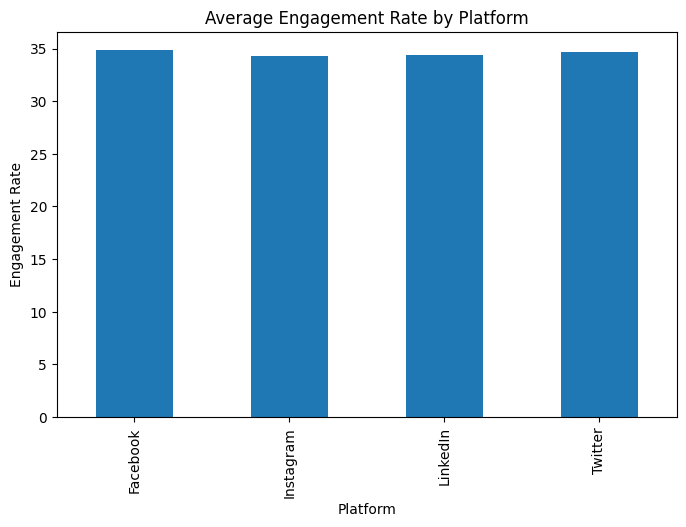

In [ ]:
## Average Engagement by Platform
platform_engagement = df.groupby('Platform')['Engagement Rate'].mean()
platform_engagement.plot(kind='bar', title='Average Engagement Rate by Platform', figsize=(8, 5))
plt.xlabel("Platform")
plt.ylabel("Engagement Rate")
plt.show()

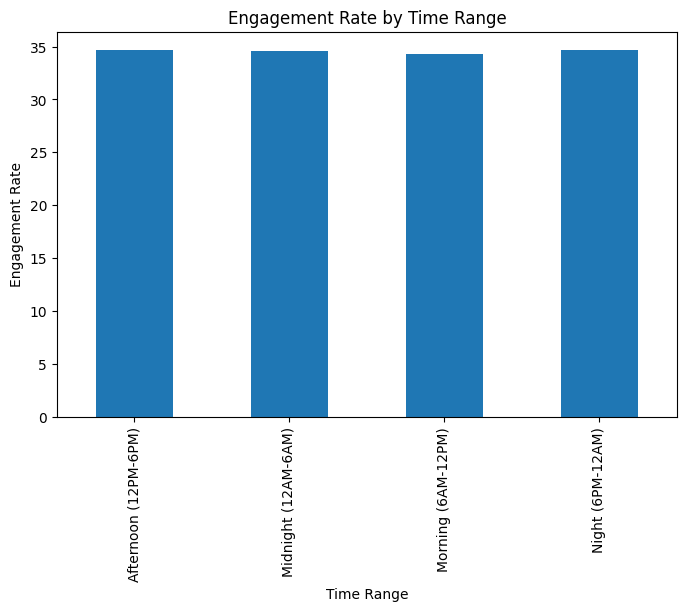

In [ ]:
## Average Engagement by Time Range
time_engagement = df.groupby('Time Range')['Engagement Rate'].mean()
time_engagement.plot(kind='bar', title='Engagement Rate by Time Range', figsize=(8, 5))
plt.xlabel("Time Range")
plt.ylabel("Engagement Rate")
plt.show()

<ipython-input-18-c09a4336201b>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  post_type_engagement = df.groupby('Post Type')['Engagement Rate'].mean()


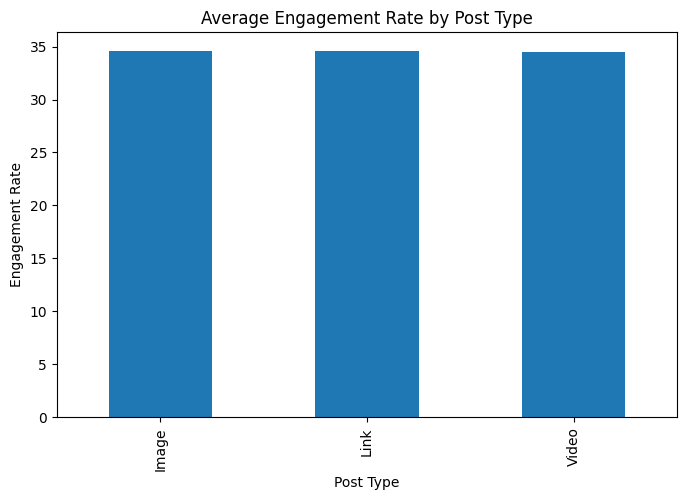

In [ ]:
## Average Engagement by Post Type
post_type_engagement = df.groupby('Post Type')['Engagement Rate'].mean()
post_type_engagement.plot(kind='bar', title='Average Engagement Rate by Post Type', figsize=(8, 5))
plt.xlabel("Post Type")
plt.ylabel("Engagement Rate")
plt.show()

<ipython-input-19-57155beedadd>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_engagement = df.groupby('Audience Gender')['Engagement Rate'].mean()


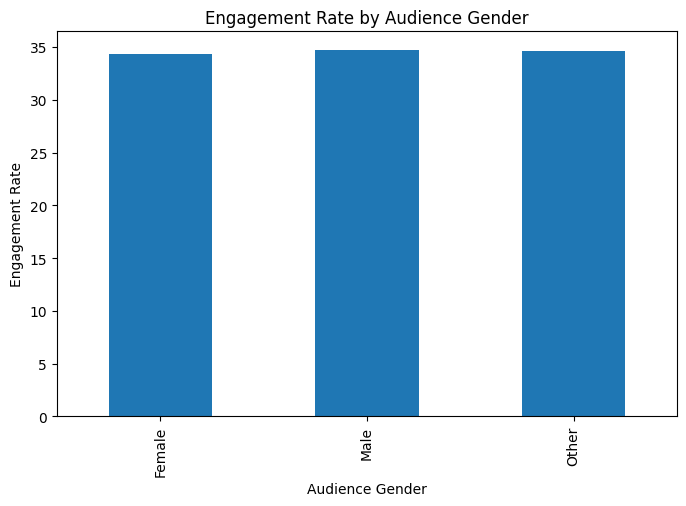

In [ ]:
## Engagement by Audience Gender
gender_engagement = df.groupby('Audience Gender')['Engagement Rate'].mean()
gender_engagement.plot(kind='bar', title='Engagement Rate by Audience Gender', figsize=(8, 5))
plt.xlabel("Audience Gender")
plt.ylabel("Engagement Rate")
plt.show()

In [ ]:
# Save the cleaned dataset
cleaned_file_path = '/content/drive/MyDrive/FinalDW_Cleaned.csv'
df.to_csv(cleaned_file_path, index=False)

print(f"Cleaned dataset saved successfully at: {cleaned_file_path}")

Cleaned dataset saved successfully at: /content/drive/MyDrive/FinalDW_Cleaned.csv


In [ ]:
# 1. Sentiment Table
sentiment_table = pd.DataFrame({
    'sentiment': ['Positive', 'Neutral', 'Negative']
})
sentiment_table['sentiment_id'] = range(1, len(sentiment_table) + 1)

# Merge sentiment_id into the main DataFrame
df = df.merge(sentiment_table, left_on='Sentiment', right_on='sentiment', how='left')
df = df.drop(columns=['sentiment'], errors='ignore')

# Save the Sentiment Table
sentiment_table = sentiment_table[['sentiment_id', 'sentiment']]
sentiment_table.to_csv('/content/drive/MyDrive/sentiment.csv', index=False)

# 2. Platforms Table
platforms = df[['Platform']].drop_duplicates().reset_index(drop=True)
platforms['platform_id'] = range(1, len(platforms) + 1)

# Merge platform_id into the main DataFrame
df = df.merge(platforms, on='Platform', how='left')

# Save Platforms Table
platforms = platforms[['platform_id', 'Platform']]
platforms.to_csv('/content/drive/MyDrive/platforms.csv', index=False)

# 3. Audience Demographics Table
audience_demographics = df[['Audience Gender', 'Audience Age', 'Audience Location', 'Audience Interests']]
audience_demographics = audience_demographics.drop_duplicates().reset_index(drop=True)
audience_demographics['audience_id'] = range(1, len(audience_demographics) + 1)

# Merge audience_id into the main DataFrame
df = df.merge(audience_demographics, on=['Audience Gender', 'Audience Age', 'Audience Location', 'Audience Interests'], how='left')

# Save Audience Demographics Table
audience_demographics = audience_demographics[['audience_id', 'Audience Gender', 'Audience Age', 'Audience Location', 'Audience Interests']]
audience_demographics.to_csv('/content/drive/MyDrive/audience_demographics.csv', index=False)

# 4. Post Details Table (Ensure platform_id and sentiment_id exist in df)
post_details = df[['Post ID', 'platform_id', 'sentiment_id', 'Post Type',
                   'Post Timestamp', 'Post Content', 'Post Hour', 'Post Minute']].copy()

# Save Post Details Table
post_details.to_csv('/content/drive/MyDrive/post_details.csv', index=False)

# 5. Engagement Metrics Table
engagement_metrics = df[['Post ID', 'audience_id', 'platform_id', 'sentiment_id',
                         'Likes', 'Comments', 'Shares', 'Reach', 'Impressions', 'Engagement Rate']].copy()

# Save Engagement Metrics Table
engagement_metrics.to_csv('/content/drive/MyDrive/engagement_metrics.csv', index=False)

print("All tables successfully split")


All tables successfully split


In [ ]:
# Step 7: Normalization and Encoding (Separate Copy)
df_transformed = df.copy()
scaler = MinMaxScaler()
df_transformed[numerical_columns] = scaler.fit_transform(df_transformed[numerical_columns])
encoder = LabelEncoder()
for col in ['Platform', 'Post Type', 'Audience Gender', 'Audience Location', 'Sentiment']:
    df_transformed[col] = encoder.fit_transform(df_transformed[col])
df_transformed.to_csv('/content/drive/MyDrive/FinalDW_Transformed.csv', index=False)

print("Normalized and Encoded dataset saved as 'FinalDW_Transformed.csv'.")

Normalized and Encoded dataset saved as 'FinalDW_Transformed.csv'.
